# Predicting the directional and future price of bitcoin.

**OVERVIEW**

Predicting the future price for bitcoin.  Firstly, predicting whether the bitcoin price will decline or increase in value, and for what time frames.  And secondly, predicting the actual future price of bitcoin, for a time frame.


### Data Sources
Data sources include free and paid bitcoin historical data.  And may include additional data sets, as required.  

Providing bitcoin historical prices, volume data, technical indicators (RSI), open interest ratios, liquidity levels, the order book, on chain activity, options and their expirations, and market sentiment.  

*Including these data sources:*
- https://github.com/ff137/bitstamp-btcusd-minute-data
- https://finance.yahoo.com
- https://www.bybit.com/future-activity/en/developer
- https://hyblockcapital.com/api-explorer
- https://api.santiment.net


### Data Understanding

Data Consists of Bitmex historical price data in minutes, for Bitcoin.  For **1/1/2012** thru **4/18/2024**.  

*And includes the following columns:*
- timestamp, date and time of the transaction
- open, opening price of bitcoin
- low, low price of bitcoin
- high, high price of bitcoin
- close, close price of bitcoin

Taken from: https://github.com/ff137/bitstamp-btcusd-minute-data

**Additional Data** has been added from: https://finance.yahoo.com

*And includes the following columns:*
- MSTR, Microstrategy Daily Close Price
- ETH-USD, Ethereum Daily Close Price
- ^SPX, Standard and Poor 500 Daily Close Prie




#### Libraries

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima, ARIMA, model_selection
import yfinance as yf

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVR
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import warnings

# suppress only the sklearn rename warning
warnings.filterwarnings(
    "ignore",
    message=".*'force_all_finite' was renamed to 'ensure_all_finite'.*",
    category=FutureWarning
)


#### Useful functions for plotting and Data Manipulation

In [ ]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Function to Add the asset's daily closing price as a column to the dataframe
def add_column_with_asset_close(ticker):
    # Account for gap days with the forward fill.  stocks do not trade 24/7, like bitcoin does.
    asset = yf.download(ticker, start="2011-12-30", end="2025-04-18", interval="1d", progress=False, group_by='ticker', auto_adjust=True)  
    asset_close = asset[ticker]['Close'].asfreq('D').ffill()

    column_name = ticker.lower() + ''
    
    asset_close.name = column_name
    df[column_name] = asset_close
    df[column_name] = df[column_name].ffill()    

# Function to add additional bitcoin data, as a column    
def add_column_with_data(data_source_file_name, column_to_import, column_prefix=''):
    df_temp = pd.read_csv(
            f'{DATA_DIR}{data_source_file_name}'
        )

    if "timestamp" in df_temp.columns:
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'], unit='ms') # timestamp is in ms
    else:
        df_temp['timestamp'] = pd.to_datetime(df_temp['openDate'], unit='s') # openDate is in seconds

    # set the datetime timestamp to the index - for date comparison analysis
    df_temp.set_index('timestamp', inplace=True)

    # Resample to daily, account for how these fields should be Aggregated.  open, high, low, close and volume.
    df_temp = df_temp.resample('D').agg({
        column_to_import: 'mean'
    }).round(6)

    # Add new column to existing dataframe
    df[column_prefix + column_to_import] = df_temp[column_to_import]    
  
# Create sequences used by LSTM model
def create_sequences(data, target_index, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_index])  
    return np.array(X), np.array(y)  

def add_column_with_ratio(new_column_name, column_a, column_b):
    # modify - need the ratio
    df[new_column_name] = df[column_a]/df[column_b]

    # drop columns no longer needed
    df.drop([column_a, column_b], axis=1, inplace=True)



#### Load the Data

In [39]:
# Load historical and recent data
DATA_DIR = 'data/'
df_hist = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_2012-2025.csv.gz',
    compression='gzip'
)
df_recent = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_latest.csv'
)

# Combine the datasets
df = pd.concat([df_hist, df_recent], ignore_index=True)



### Data Exploration
Bitcoin Pricing Data is in minute data.  Data has been cleaned and validated.  Missing data has been added. 

By using pricing data from https://github.com/ff137/bitstamp-btcusd-minute-data

Duplicates if any will be dropped.  The data will be transformed to daily, rather than minute data.  And correlated assets will be added.


In [5]:
# Information about the df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB


,timestamp,open,high,low,close,volume
0,1325412060,4.58,4.58,4.58,4.58,0.0
1,1325412120,4.58,4.58,4.58,4.58,0.0
2,1325412180,4.58,4.58,4.58,4.58,0.0
3,1325412240,4.58,4.58,4.58,4.58,0.0
4,1325412300,4.58,4.58,4.58,4.58,0.0


#### Clean and Prepare the Data

In [40]:
#Check for Missing Values
missing_counts = df.isnull().sum().sort_values()
print(missing_counts)

# drop nulls, if any
df = df.dropna()

df.info()

# Remove duplicates, if any.
print("Before removing duplicates:", df.shape)

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB
Before removing duplicates: (6992075, 6)
After removing duplicates: (6992075, 6)


In [41]:
# convert unix timestamp to datetime timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # timestamp is in seconds

# set the datetime timestamp to the index - for date comparison analysis
df.set_index('timestamp', inplace=True)

# avg, initial values - will be calculated with resample below - increases MAPE to 1.98 from 1.92
df['avg_open'] = df['open']
df['avg_close'] = df['close']

# Resample to daily, account for how these fields should be Aggregated.  open, high, low, close and volume.
df = df.resample('D').agg({
        'open':    'first',
        'avg_open':'mean',
        'high':    'max',
        'low':     'min',
        'close':   'last',
        'avg_close':'mean',
        'volume':  'sum'
    }).round(2)

#### Add Additional Bitcoin Data
- Funding Rate
- Long/Short Ratio
- Open Interest
- Taker Buy/Sell Volume


In [8]:
# Add Bitcoin Funding Rate - column
add_column_with_data ('funding_rate.csv','funding_rate')

# Add Long Short Ratio - column
add_column_with_data ('long_short_ratio.csv', 'long_short_ratio')

# Add Open Interest - column
add_column_with_data ('open_interest.csv', 'sum_open_interest_value')

# Add Take Buy/Sell Volume - column
add_column_with_data ('taker_buy_sell_volume.csv', 'buy_sell_ratio')

# hyblock api - column
add_column_with_data('anchoredCLSD.csv', 'cumulativeDelta', 'anchored_clsd_')

# hyblock api - column
add_column_with_data('anchoredCVD.csv', 'cumulativeDelta', 'anchored_cvd_')

# hyblock api - column
add_column_with_data('anchoredOIDelta.csv', 'cumulativeDelta', 'anchored_oi_')

# hyblock api - column
add_column_with_data('asksIncreaseDecrease.csv', 'asks_increase_decrease')

# hyblock api - column
add_column_with_data('averageLeverageDelta.csv', 'avgLevDelta')

# hyblock api - column
add_column_with_data('bidAskDelta.csv', 'bidAskDelta')

# hyblock api - column
add_column_with_data('bidAskRatio.csv', 'bidAskRatio')

# hyblock api - column
add_column_with_data('bidAskRatioDiff.csv', 'bidAskRatioDiff')

# hyblock api - column
add_column_with_data('bidsIncreaseDecrease.csv', 'bids_increase_decrease')

# hyblock api - column
add_column_with_data('binanceGlobalAccounts.csv', 'lsRatio')

# hyblock api - column
add_column_with_data('binanceTopTraderAccounts.csv', 'lsRatio', 'top_trader_')

# hyblock api - column
add_column_with_data('binanceTopTraderPositions.csv', 'lsRatio', 'top_position_')

# hyblock api - column
add_column_with_data('binanceTrueRetailLongShort.csv', 'longPct', 'retail_')

# hyblock api - column
add_column_with_data('binanceTrueRetailLongShort.csv', 'shortPct', 'retail_')

# add the ratio, add removing the non-ratio
add_column_with_ratio("retail_long_short_ratio", "retail_longPct", "retail_shortPct")

# hyblock api - column
add_column_with_data('binanceWhaleRetailDelta.csv', 'whaleRetailDelta')

# hyblock api - column
add_column_with_data('bybitGlobalAccounts.csv', 'lsRatio', 'bybit_')

# hyblock api - column
add_column_with_data('combinedBook.csv', 'combinedBook', '')

# hyblock api - column
add_column_with_data('fearAndGreed.csv', 'value', 'fear_greed_')

# hyblock api - column
add_column_with_data('fundingRate.csv', 'indicativeFundingRate', 'funding_')

# hyblock api - column
add_column_with_data('klines.csv', 'close', 'klines_')

# hyblock api - column
add_column_with_data('limitOrderAverageSize.csv', 'delta', 'limit_order_')

# hyblock api - column
add_column_with_data('liquidation.csv', 'longLiquidation', '')

# hyblock api - column
add_column_with_data('liquidation.csv', 'shortLiquidation', '')

# add ratio
add_column_with_ratio('liquidation_ratio', 'longLiquidation', 'shortLiquidation')


# liquidationLevels.csv - is only current day.

# hyblock api - column
add_column_with_data('marginLendingRatio.csv', 'marginLendingRatio', '')

# hyblock api - column
add_column_with_data('marketOrderAverageSize.csv', 'delta', 'mkt_order_')

# hyblock api - column
add_column_with_data('marketOrderCount.csv', 'delta', 'mkt_order_cnt_')

# hyblock api - column
add_column_with_data('netLongShortDelta.csv', 'netLongShortDelta', '')

# hyblock api - column
add_column_with_data('openInterestDelta.csv', 'openInterestDelta', '')

# hyblock api - column
add_column_with_data('participationratio.csv', 'participation_ratio', '')

# hyblock api - column
add_column_with_data('pdLevels.csv', 'pdEq', '')

# hyblock api - column
add_column_with_data('pmLevels.csv', 'pdEq', 'pm_')

# hyblock api - column
add_column_with_data('pwLevels.csv', 'pdEq', 'pw_')

# hyblock api - column
add_column_with_data('slippage.csv', 'averageMax', 'slippage_')

# hyblock api - column
add_column_with_data('stablecoinPremiumP2P.csv', 'usdcPremium', '')

# hyblock api - column
add_column_with_data('stablecoinPremiumP2P.csv', 'usdtPremium', '')

# hyblock api - column
add_column_with_data('traderSentimentGap.csv', 'trader_sentiment_gap', '')

# hyblock api - column
add_column_with_data('transferofcontracts.csv', 'transfer_of_contracts', '')

# hyblock api - column
add_column_with_data('userBotRatio.csv', 'ubRatio', 'user_bot_')

# hyblock api - column
add_column_with_data('volumeDelta.csv', 'volumeDelta', '')

# hyblock api - column
add_column_with_data('wbtcMintBurn.csv', 'mint', 'wbtc_')

# hyblock api - column
add_column_with_data('wbtcMintBurn.csv', 'burn', 'wbtc_')

# add ratio
add_column_with_ratio('wbtc_mint_burn_ratio', 'wbtc_mint', 'wbtc_burn')

# hyblock api - column
add_column_with_data('whalePositionDominance.csv', 'whale_position_dominance', '')

# hyblock api - column
#add_column_with_data('.csv', '', '')


#### Add Correlated Assets 
- Micro Strategy Stock, Daily Closing Prices 
- Ethereum crypto currency, Daily Closing Prices
- S&P500 Index, Daily Closing Prices

In [31]:
TICKERS = ['MSTR', 'ETH-USD', '^SPX']
for ticker in TICKERS:
    add_column_with_asset_close(ticker)

#### Target 'y' is the next day's closing price, 

In [42]:
df['y'] = df['close'].shift(-1) # target y, we want to predict with historical open, close... tomorrow's 'close'

# drop last row, to avoid 0 value
df = df[:-1] 

df = df.replace([np.inf, -np.inf], 0)

# final data cleanup, not all assets added have data.  For example, ethereum wasn't traded until 2015, and we have bitcoin data since 2012
df = df.fillna(0)

#df.head()
df.tail()

,open,avg_open,high,low,close,avg_close,volume,y
timestamp,,,,,,,,
2025-04-13,85277.0,84443.51,86084.0,83031.0,83712.0,84435.62,1210.92,84583.0
2025-04-14,83774.0,84667.64,85787.0,83680.0,84583.0,84661.68,1425.88,83686.0
2025-04-15,84583.0,85019.76,86450.0,83612.0,83686.0,85018.30,1162.91,84046.0
2025-04-16,83632.0,84005.18,85528.0,83102.0,84046.0,84001.82,1593.45,84954.0
2025-04-17,84045.0,84578.22,85478.0,83751.0,84954.0,84575.29,1119.59,84864.0


### Exploratory Data Analysis

#### Explore Correlations

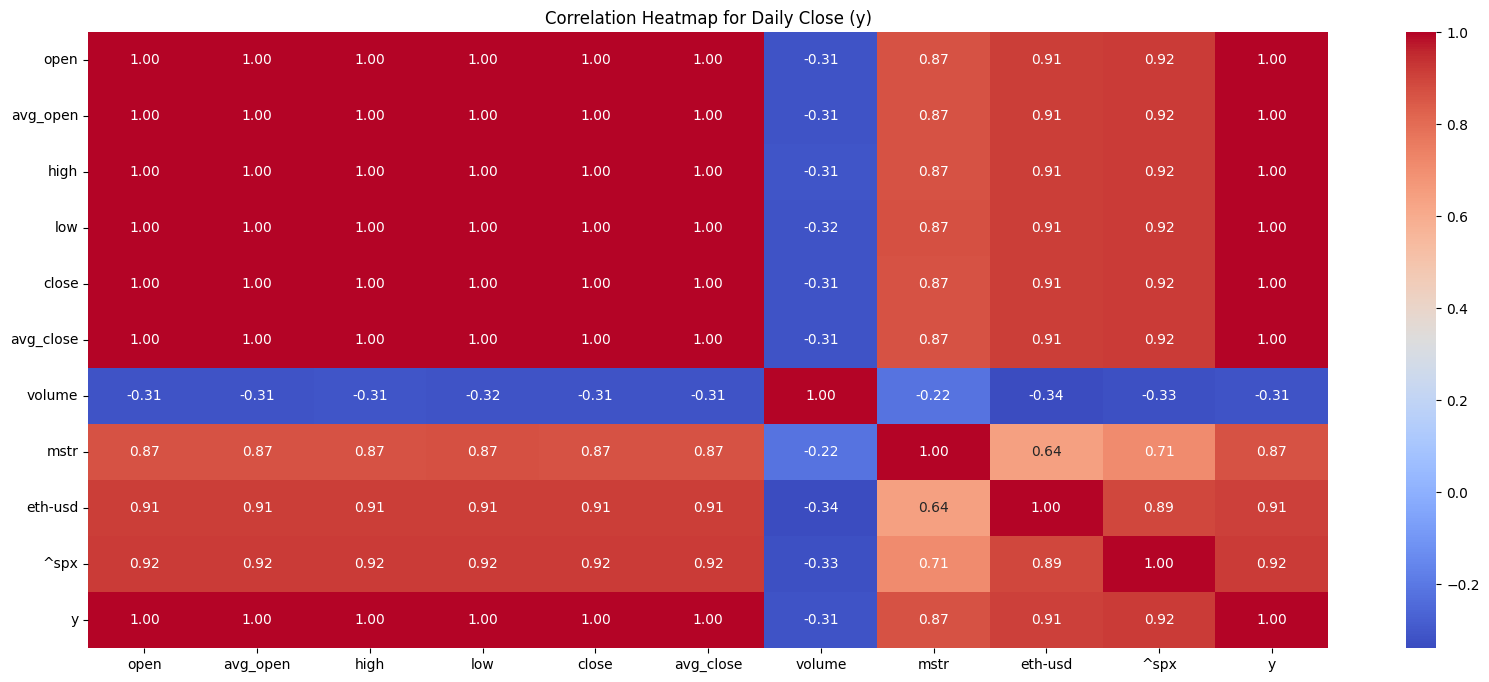

In [33]:
# heatmap of correlation matrix
numerical_subset_df = df.select_dtypes(include=['int64', 'float64'])
corr = numerical_subset_df.corr()

plt.figure(figsize=(20, 8))  # Adjust the size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for Daily Close (y)')
plt.show()

#### Plots of the Closing Price - 'y' target 

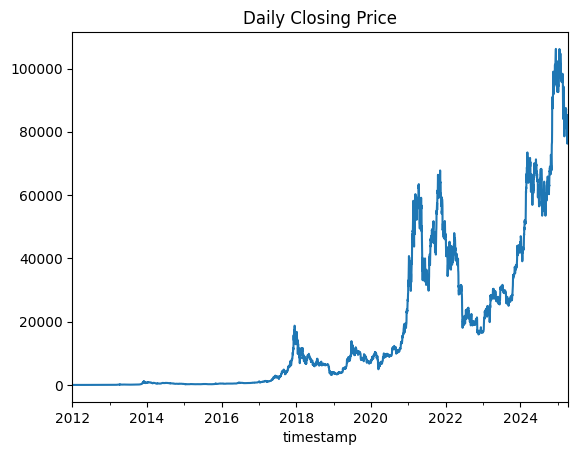

In [12]:
# Daily Closing Price  Plot
df['y'].plot(title = 'Daily Closing Price')
plt.show()

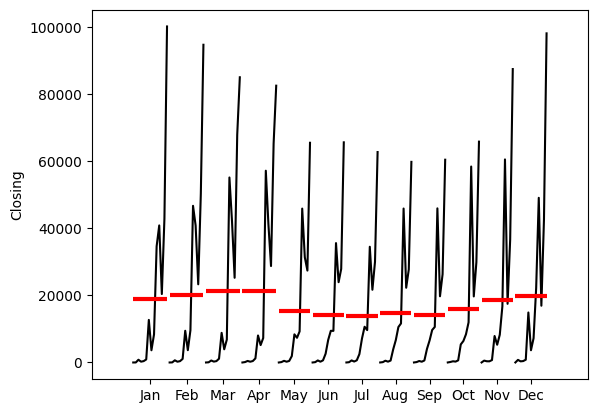

In [13]:
# Plotting the monthly seasonality
month_plot(df['y'].resample('ME').mean(),
           ylabel = 'Closing')
plt.show()

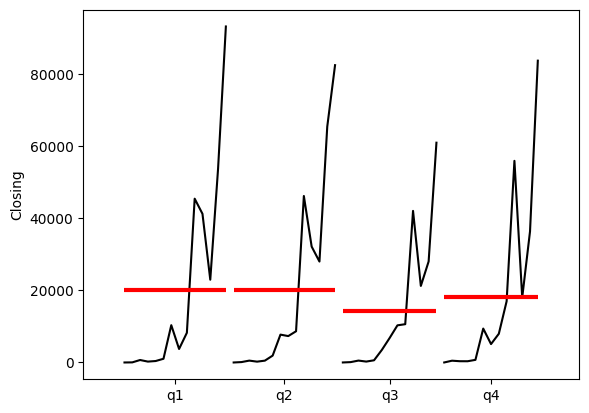

In [14]:
# Plotting the quarterly seasonality
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Closing')
plt.show()

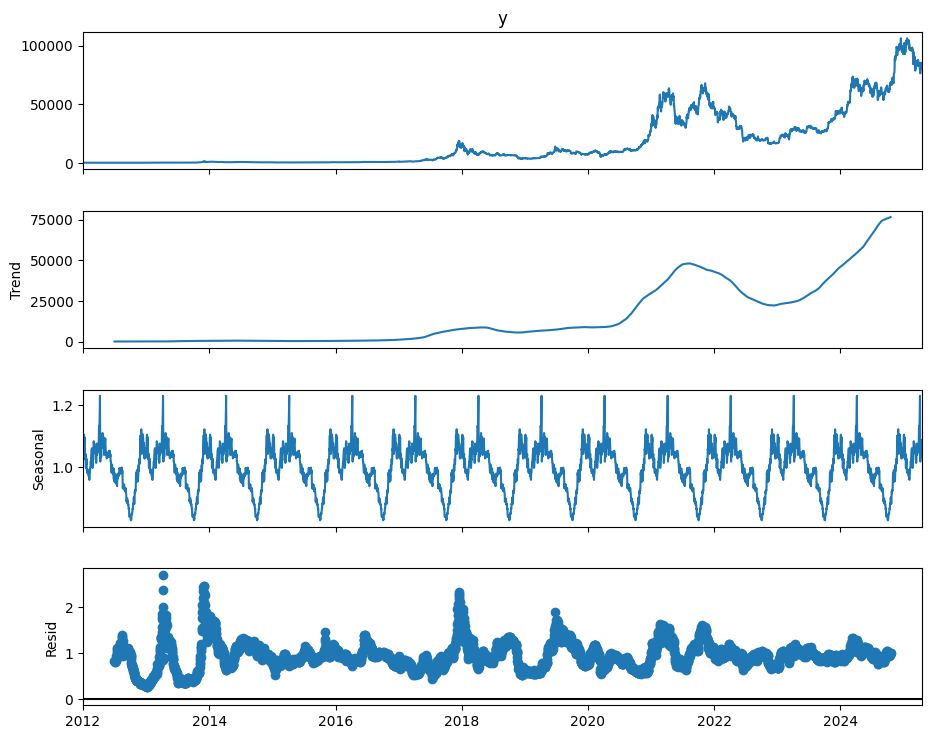

In [15]:
# Seasonal Decomposition Plots for Bitcoin Data
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

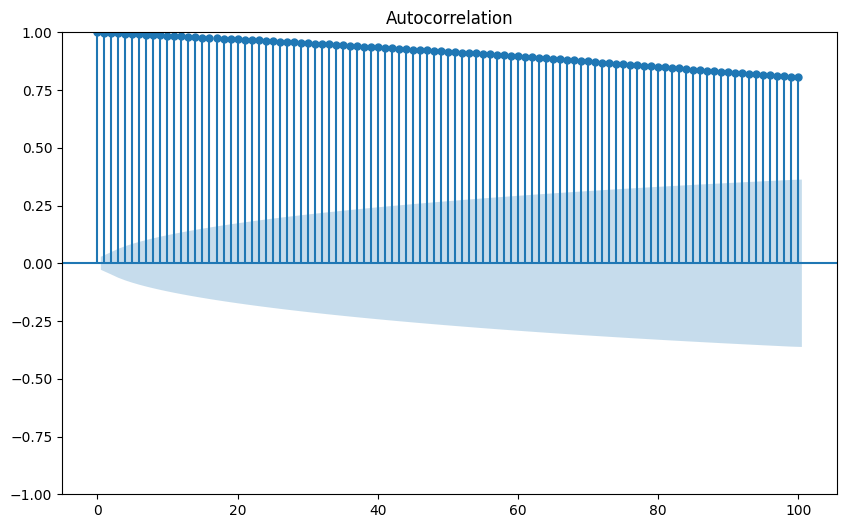

In [16]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

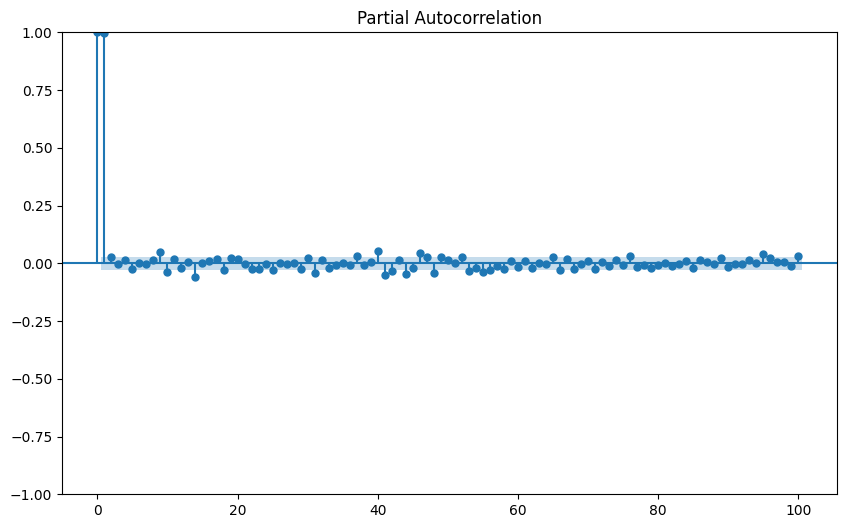

In [17]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

### Feature Engineering

An initial model, for predicting Bitcoin's future price.

In [43]:
X = df.drop(['y'], axis=1)
y = df['y']  # target variable

In [44]:
# Train/Test, 20% for Test.  Split the data - shuffle off - timeseries, in order... a chronological split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [45]:
print(X_train)

                open  avg_open      high       low     close  avg_close  \
timestamp                                                                 
2012-01-01      4.58      4.65      4.84      4.58      4.84       4.65   
2012-01-02      4.84      4.97      5.00      4.84      5.00       4.97   
2012-01-03      5.00      5.09      5.32      5.00      5.29       5.09   
2012-01-04      5.29      5.17      5.57      4.93      5.57       5.17   
2012-01-05      5.57      5.95      6.46      5.57      6.42       5.95   
...              ...       ...       ...       ...       ...        ...   
2022-08-15  24300.00  24315.46  25212.00  23900.00  23982.00   24314.69   
2022-08-16  23997.00  23998.77  24250.00  23673.00  23941.00   23998.38   
2022-08-17  23945.00  23798.10  24448.00  23240.00  23279.00   23797.74   
2022-08-18  23281.00  23417.61  23593.00  23176.00  23341.00   23418.00   
2022-08-19  23351.00  22210.01  23450.00  21156.00  21334.00   22209.09   

             volume  
ti

#### Initial Base Model to Beat, **SARIMAX** on a weekly period

In [46]:
# sarimax, 7 day period
model_sarimax = auto_arima(y_train,
                           m = 7,
                           X = X_train,
                           enforce_invertibility=False, 
                           enforce_stationarity=False)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                 3884
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood              -30980.244
Date:                   Tue, 13 May 2025   AIC                          61978.489
Time:                           16:20:15   BIC                          62034.871
Sample:                       01-01-2012   HQIC                         61998.505
                            - 08-19-2022                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open           0.0371      0.017      2.187      0.029       0.004       0.070
avg_open      31.5650     14.128      2.234      0.025       3.876      59.255
high           0.3343      0.021     15.964      0.000       0.293       0.375
low            0.2411      0.014     17.406      0.000       0.214       0.268
close          0.9103      0.016     56.491      0.000       0.879       0.942
avg_close    -32.0899     14.123     -2.272      0.023     -59.771      -4.409
volume         0.0011      0.002      0.600      0.548      -0.002       0.005
ma.S.L7       -0.0297      0.007     -4.139      0.000      -0.044      -0.016
sigma2      4.992e+05      0.011   4.46e+07      0.000    4.99e+05    4.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             61883.37
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):            2164.75   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.55e+23. Standard errors may be unstable.
"""

#### Forecast using SARIMAX Model

In [47]:
# Use the fitted Sarimax model to forecast future values.
predictions_arima = model_sarimax.predict(X=X_test, n_periods = len(X_test)) # set the number of periods to forecast to the length of 'test'
predictions_arima

2022-08-20    20974.946631
2022-08-21    21437.194233
2022-08-22    21101.760623
2022-08-23    21475.256608
2022-08-24    21720.330140
                  ...     
2025-04-13    84099.022986
2025-04-14    84713.998014
2025-04-15    83803.178637
2025-04-16    84258.411134
2025-04-17    84924.966805
Freq: D, Length: 972, dtype: float64

#### SARIMAX Model Assessment

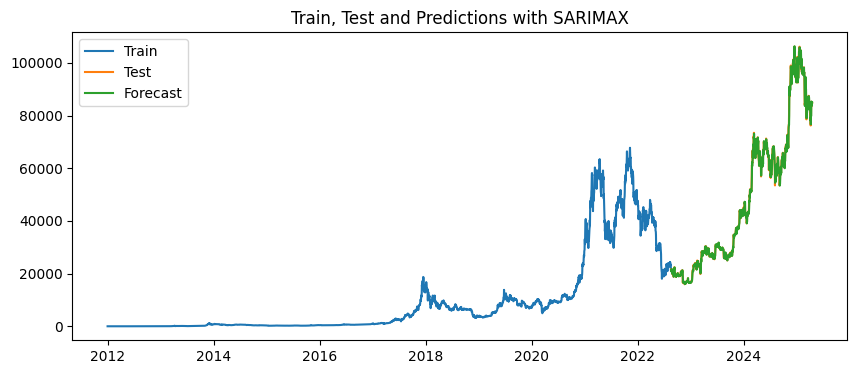

The MAE is 918.11
The RMSE is 1471.64
The MAPE is 1.80 %


In [50]:
# Model assessment
model_assessment(y_train, y_test, predictions_arima, "SARIMAX")

#### Model Exploration

##### Standardize the Data

In [62]:
# Transform the data, standardize
preprocessor = ColumnTransformer(transformers=[('numeric', StandardScaler(), X.columns)])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [75]:
# Define models 
models = {"SVR": SVR(), "Linear Regression": LinearRegression(), "Ridge": Ridge(), "Lasso": Lasso(max_iter=10000), "Random Forest Regressor": RandomForestRegressor(random_state=42), "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42), "XGBoost Regressor": XGBRegressor(random_state=42)  }
results = {"Model":[], "Model Predictions":[], "Best Model":[], "Best Parameters":[], "Train Time":[], "Train MAE":[], "Test MAE":[], "Test RMSE":[], "Test MAPE":[]}

In [ ]:
# Hyperparameter grids for each model
param_grids = {
    'SVR': {
        'kernel':   ['rbf', 'poly', 'linear', 'sigmoid'],
        'C':        [ 1, 100],   
        'gamma':    [0.001, 0.1, 1]
    },
    'Linear Regression': {
        'fit_intercept': [False, True]
    },
    'Ridge': {
        'alpha': [0.1, 0.001, 1, 10],
        'fit_intercept': [False, True]
    },
    'Lasso': {
        'alpha': [10, 50, 100],
        'tol': [1e-4], #[1e-4, 1e-3, 1e-2],
        'fit_intercept': [True]
    },
    'Random Forest Regressor': {
        'n_estimators': [100, 300, 500],
        'max_depth':    [None, 10, 30],
        'max_features': ['sqrt', 'log2', 0.5, None]
    },
    'Gradient Boosting Regressor': {
        'learning_rate':  [0.01], # 0.05, 0.1, 0.2],
        'n_estimators':   [100, 200, 500],
        'max_depth':      [2],# 3, 5],
        'subsample':      [0.6, 0.8, 1.0]
    },
    'XGBoost Regressor': {
        'n_estimators':      [100, 500],
        'learning_rate':     [0.05, 0.1],
        'max_depth':         [3, 5],
        'subsample':         [0.8, 1.0],
        'colsample_bytree':  [0.8, 1.0],
        'gamma':             [0, 0.1],
        'reg_alpha':         [0, 0.1],
        'reg_lambda':        [1, 1.5]
    }
}


In [ ]:
# go thru each model, predict, and score
for model_name, model in models.items():
    train_time_start = time.time()
    
    print(f"Tuning {model_name}...")

    params = param_grids[model_name]
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='neg_mean_absolute_error',
        verbose=1,
        cv=5
    )

    # Fit the grid search
    grid_search.fit(X_train_processed, y_train)
    train_time = time.time() - train_time_start
    
    y_train_predict = grid_search.predict(X_train_processed)
    train_mae = mean_absolute_error(y_train_predict, y_train)

    y_test_predict = grid_search.predict(X_test_processed)
    test_mae = mean_absolute_error(y_test_predict, y_test)
    test_rmse = root_mean_squared_error(y_test_predict, y_test)
    test_mape = round(mean_absolute_percentage_error(y_test_predict, y_test), 2)*100

    results["Model"].append(model_name)
    results["Best Model"].append(grid_search.best_estimator_)
    print(model_name)
    results["Best Parameters"].append(grid_search.best_params_)
    print(grid_search.best_params_)
    results["Model Predictions"].append(y_test_predict)
    results["Train Time"].append(train_time)
    results["Train MAE"].append(train_mae)
    
    results["Test MAE"].append(test_mae)
    results["Test RMSE"].append(test_rmse)
    results["Test MAPE"].append(str(test_mape) + " %")
    

Tuning SVR...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuning Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tuning Ridge...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuning Lasso...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Tuning Random Forest Regressor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Tuning Gradient Boosting Regressor...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tuning XGBoost Regressor...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits


In [80]:
# Display the Model Results - dataframe, then print
data_frame_results = pd.DataFrame(results).drop('Model Predictions', axis=1)

print ("Model Results:")
print (data_frame_results)

Model Results:
                          Model  \
0                           SVR   
1             Linear Regression   
2                         Ridge   
3                         Lasso   
4       Random Forest Regressor   
5   Gradient Boosting Regressor   
6             XGBoost Regressor   
7                           SVR   
8             Linear Regression   
9                         Ridge   
10                        Lasso   
11      Random Forest Regressor   
12  Gradient Boosting Regressor   
13            XGBoost Regressor   

                                           Best Model  \
0            SVR(C=100, gamma=0.001, kernel='linear')   
1                                  LinearRegression()   
2                                  Ridge(alpha=0.001)   
3                     Lasso(alpha=10, max_iter=10000)   
4   (DecisionTreeRegressor(max_depth=10, random_st...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   XGBRegressor(base_score=None, booster=None, ca...   
7  

In [ ]:
# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create Sequences for all data
target_index = df.columns.get_loc('y')
X, y = create_sequences(scaled_data, target_index, seq_len=30)

# Train/Test, 20% for Test.  Split the data - shuffle off - timeseries, in order... a chronological split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Create and Train LSTM Model

model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')




2025-05-12 14:40:39.983583: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-12 14:40:39.983619: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-12 14:40:39.983629: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-12 14:40:39.983893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-12 14:40:39.984235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
import google.protobuf as pb
print(pb.__version__)

import tensorflow as tf
print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


3.20.3
TF version: 2.14.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20


: 

In [ ]:
#predict 
predictions = model.predict(X)
# Reverse scale only the target (Close) values
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[target_index], scaler.scale_[target_index]
predicted_close = close_scaler.inverse_transform(predictions)


151/151 [==============================] - 1s 3ms/step


In [ ]:
actual_close = scaler.inverse_transform(
    np.concatenate([np.zeros((y.shape[0], target_index)),
                    y.reshape(-1, 1),
                    np.zeros((y.shape[0], df.shape[1] - target_index - 1))], axis=1)
)[:, target_index]

In [ ]:
rmse = root_mean_squared_error(actual_close, predicted_close)
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 1046139.5247899116


In [ ]:
mape = mean_absolute_percentage_error(actual_close, predicted_close)
print(f"MAPE: {mape * 100:.2f}%")

MAPE: 136.79%
